In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# Please replace the brackets below with the drive location of your folders which included subfolders for images
# Sample path: /content/drive/My Drive/ImageClassification
TRAINING_PATH = '/content/drive/Shareddrives/ResearchPrograms_V2/Rishi_Skin_Lesion_classification/Processed_Data/Train'
VALIDATION_PATH = '/content/drive/Shareddrives/ResearchPrograms_V2/Rishi_Skin_Lesion_classification/Processed_Data/Valid'

In [ ]:
def create_model(base_model, num_classes):
    import tensorflow as tf
    # Grab the last layer and add a few extra layers to it
    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    # Dense layer 1
    x=tf.keras.layers.Dense(100,activation='relu', kernel_initializer=tf.keras.initializers.VarianceScaling(), use_bias=True)(x)

    # Final layer with softmax activation
    preds=tf.keras.layers.Dense(num_classes,activation='softmax', kernel_initializer=tf.keras.initializers.VarianceScaling(), use_bias=False)(x)

    # Create the final model
    model=Model(inputs=base_model.input,outputs=preds)
    return model


In [ ]:
def get_optimizer(optimizer_name, learning_rate):
    # Import keras optimizers
    from tensorflow.keras.optimizers import Adam, Adadelta, Adagrad, Adamax, Ftrl, Nadam, RMSprop, SGD
    print('Selected Optimizer', optimizer_name)
    switcher = {
        'Adadelta': Adadelta(learning_rate=learning_rate),
        'Adagrad': Adagrad(learning_rate=learning_rate),
        'Adam': Adam(learning_rate=learning_rate),
        'Adamax': Adamax(learning_rate=learning_rate),
        'FTRL': Ftrl(learning_rate=learning_rate),
        'NAdam': Nadam(learning_rate=learning_rate),
        'RMSprop': RMSprop(learning_rate=learning_rate),
        'Gradient Descent': SGD(learning_rate=learning_rate)
    }
    # If optimizer_name is empty, Adam will be return as default optimizer
    return switcher.get(optimizer_name, Adam(learning_rate=learning_rate))


In [ ]:

# Import packages needed to create a image classification model
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from keras.applications.mobilenet_v2 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras import regularizers

from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.callbacks import EarlyStopping
from tensorflow import keras

# Initialize hyper params
epochs = 40 #<-- increase for higher accuracy
base_learning_rate = 0.001#decrease for different results; use excel sheet to note down results from each change to learning rate and epochs
optimizer = 'Adam'
BATCH_SIZE = 32

IMG_SIZE = (224, 224)

# Create the data generation pipeline for training and validation
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(TRAINING_PATH,
                                                target_size=IMG_SIZE,
                                                color_mode='rgb',
                                                batch_size=BATCH_SIZE,
                                                class_mode='categorical',
                                                shuffle=True,
                                                )
validation_generator = validation_datagen.flow_from_directory(VALIDATION_PATH,
                                                target_size=IMG_SIZE,
                                                color_mode='rgb',
                                                batch_size=BATCH_SIZE,
                                                class_mode='categorical',
                                                shuffle=True,
                                                )

print(validation_generator.class_indices.keys())
# Download the model, valid alpha values [0.25,0.35,0.5,0.75,1]
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet', alpha=0.35)
for layer in base_model.layers:
    layer.trainable=False

# Specify the number of classes
num_classes = 3

# Create the base model
model = create_model(base_model,num_classes)

print(len(base_model.layers))

model.compile(optimizer = get_optimizer(optimizer_name=optimizer,learning_rate=base_learning_rate),loss='CategoricalCrossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=30,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

step_size_train = train_generator.n//train_generator.batch_size
history_fine = model.fit(train_generator,
                        epochs=epochs,
                        validation_data = validation_generator,
                        verbose=1)

Found 977 images belonging to 3 classes.
Found 113 images belonging to 3 classes.
dict_keys(['ACK', 'NEV', 'SEK'])
154
Selected Optimizer Adam
Epoch 1/40
31/31 [==============================] - 51s 2s/step - loss: 0.7093 - accuracy: 0.7093 - val_loss: 0.4661 - val_accuracy: 0.8142
Epoch 2/40
31/31 [==============================] - 51s 2s/step - loss: 0.4468 - accuracy: 0.8301 - val_loss: 0.4396 - val_accuracy: 0.8142
Epoch 3/40
31/31 [==============================] - 46s 1s/step - loss: 0.3675 - accuracy: 0.8608 - val_loss: 0.4347 - val_accuracy: 0.8319
Epoch 4/40
31/31 [==============================] - 47s 2s/step - loss: 0.2996 - accuracy: 0.8997 - val_loss: 0.4798 - val_accuracy: 0.8319
Epoch 5/40
31/31 [==============================] - 46s 1s/step - loss: 0.2625 - accuracy: 0.9161 - val_loss: 0.4654 - val_accuracy: 0.7965
Epoch 6/40
31/31 [==============================] - 50s 2s/step - loss: 0.2176 - accuracy: 0.9417 - val_loss: 0.5587 - val_accuracy: 0.7611
Epoch 7/40
31/31 

In [ ]:
model.save("/content/drive/Shareddrives/ResearchPrograms_V2/Rishi_Skin_Lesion_classification/Models/e_10_lr_001_best_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


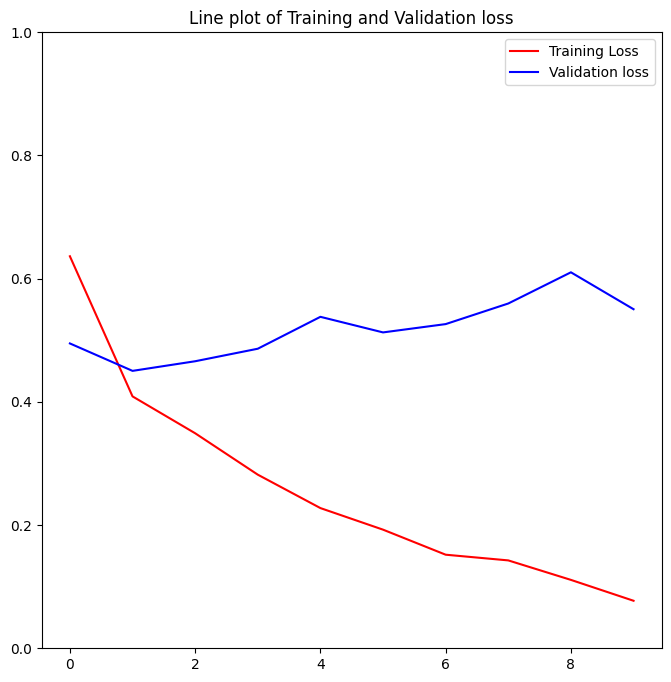

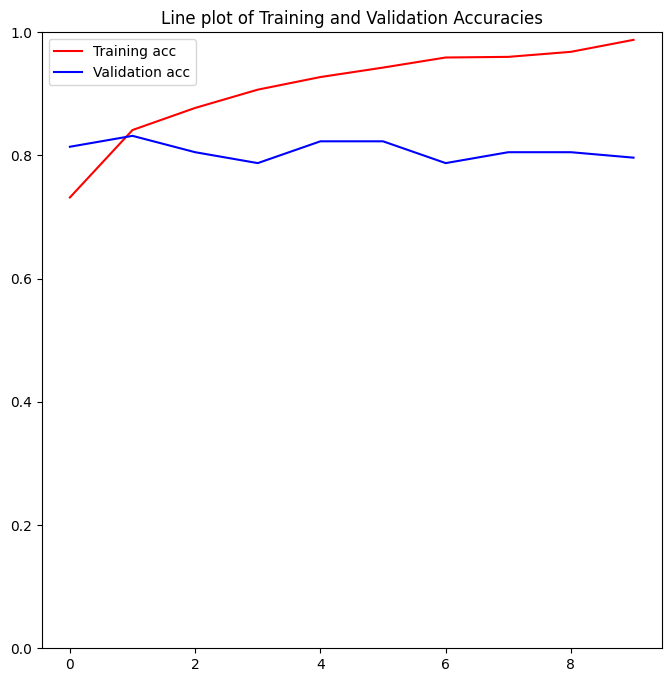

In [ ]:
def visualization():
    import pandas as pd
    df = pd.DataFrame(history_fine.history)
    #loss plots
    plt.figure(figsize=(8,8))
    plt.plot(df['loss'], color='red', label = "Training_loss")
    plt.plot(df['val_loss'], color='blue')
    plt.legend(['Training Loss','Validation loss'],loc = 'best' )
    plt.title('Line plot of Training and Validation loss')
    plt.ylim(0,1)
    plt.show()

    #accuracy plots
    plt.figure(figsize=(8,8))
    plt.plot(df['accuracy'], color='red')
    plt.plot(df['val_accuracy'], color='blue')
    plt.legend(['Training acc','Validation acc'],loc = 'best' )
    plt.title('Line plot of Training and Validation Accuracies')
    plt.ylim(0,1)
    plt.show()

visualization()

In [ ]:

# Import numpy for calculating best model accuracy
import numpy as np
# Populating matrics -> accuracy & loss
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

print('Training Accuracy: ', acc)
print('Validation Accuracy: ', val_acc)
print('Training Loss: ', loss)
print('Validation Loss: ', val_loss)
best_model_accuracy = history_fine.history['val_accuracy'][np.argmin(history_fine.history['val_loss'])]
print('best model accuracy: ', best_model_accuracy)


Training Accuracy:  [0.7318321466445923, 0.8413510918617249, 0.8771750330924988, 0.9068577289581299, 0.9273285865783691, 0.9426816701889038, 0.9590583443641663, 0.9600818753242493, 0.9682702422142029, 0.9877175092697144]
Validation Accuracy:  [0.8141592741012573, 0.8318583965301514, 0.8053097128868103, 0.7876105904579163, 0.8230088353157043, 0.8230088353157043, 0.7876105904579163, 0.8053097128868103, 0.8053097128868103, 0.7964601516723633]
Training Loss:  [0.6363825798034668, 0.4088999629020691, 0.34905898571014404, 0.281844824552536, 0.2275880128145218, 0.19257035851478577, 0.15190930664539337, 0.14265196025371552, 0.11102758347988129, 0.07714517414569855]
Validation Loss:  [0.4948650002479553, 0.45033958554267883, 0.4659554958343506, 0.4862830340862274, 0.5380765795707703, 0.5127733945846558, 0.5262598991394043, 0.5597139596939087, 0.6103403568267822, 0.550440788269043]
best model accuracy:  0.8318583965301514


In [ ]:
def seperate_labels(generator):
    x_validation = []
    y_validation = []
    num_seen = 0

    for x, labels in generator:
        x_validation.append(x)
        y_validation.append([argmax(label) for label in labels])
        num_seen += len(x)
        if num_seen == generator.n: break

    x_validation = np.concatenate(x_validation)
    y_validation = np.concatenate(y_validation)
    return x_validation, y_validation


In [ ]:

# Calculate and display the confusion matrix
import matplotlib.pyplot as plt
from numpy.core.fromnumeric import argmax
from sklearn.metrics import ConfusionMatrixDisplay

x_validation, y_validation = seperate_labels(validation_generator)
y_pred = model.predict(x_validation, batch_size=BATCH_SIZE)
predictions = np.apply_along_axis(argmax, 1, y_pred)
display_labels = validation_generator.class_indices.keys()

# ConfusionMatrixDisplay.from_predictions(y_validation, predictions, display_labels=display_labels, cmap="binary")
# plt.show()


4/4 [==============================] - 1s 24ms/step


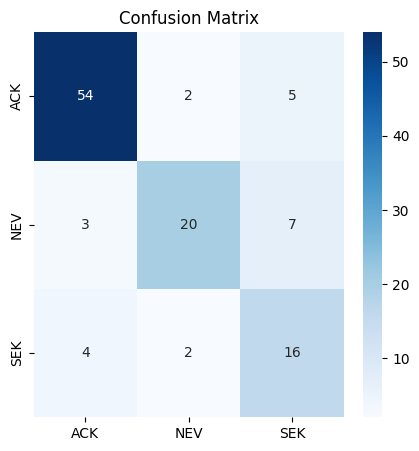

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
plt.figure(figsize = (5,5))
sns.heatmap(confusion_matrix(y_validation, predictions), annot = True, fmt = 'g', cmap = "Blues",xticklabels=display_labels, yticklabels=display_labels)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print(classification_report(y_validation, predictions))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89        61
           1       0.83      0.67      0.74        30
           2       0.57      0.73      0.64        22

    accuracy                           0.80       113
   macro avg       0.76      0.76      0.76       113
weighted avg       0.81      0.80      0.80       113



In [ ]:

# Predicting code for an image
from tensorflow.keras.preprocessing import image
# Please replace the brackets below with the location of your image which need to predict
img_path = '<>'
img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_batch)
prediction = model.predict(img_preprocessed)
print(prediction)
